<a href="https://colab.research.google.com/github/institutohumai/cursos-python/blob/master/DeepLearning/4_PyTorch_Avanzado/ejercicios/ejercicios.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab"/></a>

#Ejercicios de la clase 4

## Setup

In [ ]:
import sys

In [ ]:
import sklearn

In [ ]:
import torch
from torchvision import transforms
from torch.utils import data
import torchvision


Definiciones adicionales pra que nuestras figuras se vean "bonitas"

In [ ]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

## Aprendiendo a quitar el ruido de imágenes

En este notebook vamos a seguir trabajando sobre el dataset FashionMNIST, pero esta vez, en vez de clasificar las imágenes según la prenda que contienen, vamos a modificar las imágenes agregando un ruido aleatorio que una de nuestras redes neuronales aprenderá a quitar. 



Arranquemos cargando el dataset.

In [ ]:
torch.manual_seed(42)  # fijamos la semilla para generar reproducibilidad
batch_size = 256

# Dataloader para FashionMNIST
mnist_train = torchvision.datasets.FashionMNIST(transform=transforms.ToTensor(),
        root="../data", train=True, download=True)
mnist_test = torchvision.datasets.FashionMNIST(transform=transforms.ToTensor(),
        root="../data", train=False, download=True)
iter_train, iter_valid =  (data.DataLoader(mnist_train, batch_size, shuffle=True,
                            num_workers=2),
            data.DataLoader(mnist_test, batch_size, shuffle=True,
                            num_workers=2))

Luego vamos a crear un bloque que genere ruido mediante la capa Dropout. Esta capa multiplica por cero pixeles aleatorios de las imágenes con una probabilidad igual a un escalar que pasamos como parámetro.

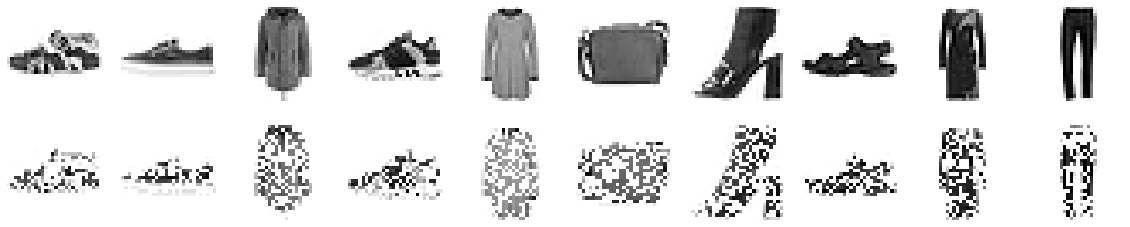

In [ ]:
p=0.5 #probabilidad de que un pixel sea eliminado
noise = torch.nn.Sequential(torch.nn.Dropout(p))

images,_ = next(iter(iter_train))
noise_images = noise(images)

n_images = 10
fig = plt.figure(figsize=(n_images * 2, 4))
for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plt.imshow(images[image_index].squeeze(),
                   cmap="binary")
        plt.axis("off")
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plt.imshow(noise_images[image_index].squeeze(),
                   cmap="binary")
        plt.axis("off")

    
    

## Denoising Autoencoders

A muy alto nivel, un `autoencoder` (codificador automático) contiene un `encoder` (codificador) y un `decoder` (decodificador). Estas dos partes funcionan automáticamente y dan lugar al nombre de `autoencoder`. El encoder transforma la entrada de alta dimensión en una dimensión más baja (espacio latente, donde la entrada está más comprimida), mientras que un decoder hace el trabajo inverso del encoder en el resultado codificado y reconstruye la imagen original. 

![Imgur](https://i.imgur.com/iOp5Vdu.png)

En la tarea de eliminación de ruido, los datos se corrompen de alguna manera para que el modelo pueda aprender a predecir la imagen original. En este caso, la idea es almacenar la salida generada por el encoder como un vector de características de la entrada (llamado vector latente) que está tan comprimido que de alguna manera guarda información solamente de la imagen subyacente y no del ruido. De esta forma, al reconstruir la imagen con el decoder teniendo en cuenta solamente el vector latente como entrada, la salida sería la imagen original sin ruido.

## Ejercicio 1: Construcción del Encoder

En este ejercicio usted deberá crear con pytorch un MLP de 2 capas (con 100 y 30 neuronas respectivamente) que reciba como entrada imágenes de 28*28 y produzca como salida vectores latentes de 30 elementos. No olvide que los MLP necesitan funciones de activación para poder apilar sus capas!!

In [ ]:
#ingrese su código aquí
encoder = #mantenga este nombre de variable durante todo el notebook para que funcionen los tests

In [ ]:
#@title Test N° 1
#@markdown Ejecutar para confirmar que su código es correcto
images,_ = next(iter(iter_train))

try:
  latentes = encoder(images)
  assert latentes.shape[1] == 30, "La salida de su red no es un vector de 30 elementos"
  print("Al parecer está todo bien. Puedes avanzar al siguiente test")
except: 
  print("Su encoder no generó una salida válida.\nLa entrada no pudo recorrer todo el camino hasta el final de su red.\nRevise que la dimensionalidad de sus capas sean compatibles")



In [ ]:
#@title Test N° 2
#@markdown Ejecutar para confirmar que su código es correcto
assert encoder[1].weight.shape == torch.Size([100, 784]), "Las dimensiones de su primera capa densa están mal"
assert encoder[3].weight.shape == torch.Size([30, 100]), "Las dimensiones de su segunda capa densa están mal"
print("Al parecer está todo bien. Puedes avanzar al siguiente ejercicio")

## Ejercicio 2: Construcción del Decoder

En este ejercicio usted deberá crear con pytorch un MLP de 2 capas que sea inverso al decoder que construyo en el ejercicio anterior (con 30 y 100 neuronas respectivamente) que reciba como entrada vectores latentes de 30 elementos y produzca como salida imágenes de 28*28 . No olvide que los MLP necesitan funciones de activación para poder apilar sus capas!! 
Tip: para revertir un Flatten() debe usar Unflatten()

In [ ]:
#ingrese su código aquí
decoder = #mantenga este nombre de variable durante todo el notebook para que funcionen los tests

In [ ]:
#@title Test N° 1
#@markdown Ejecutar para confirmar que su código es correcto
try:
  salidas = decoder(latentes)
  assert salidas.shape[1] == 28 and salidas.shape[2] == 28, "La salida de su red no es una imagen de 28*28"
  print("Al parecer está todo bien. Puedes avanzar al siguiente test")
except: 
  print("Su encoder no generó una salida válida.\nLa entrada no pudo recorrer todo el camino hasta el final de su red.\nRevise que la dimensionalidad de sus capas sean compatibles")




In [ ]:
#@title Test N° 2
#@markdown Ejecutar para confirmar que su código es correcto
assert decoder[0].weight.shape == torch.Size([100, 30]), "Las dimensiones de su primera capa densa están mal"
assert decoder[2].weight.shape == torch.Size([784, 100]), "Las dimensiones de su segunda capa densa están mal"
print("Al parecer está todo bien. Puedes avanzar al siguiente ejercicio")

## Ejercicio 3: Crear un autoencoder
En este ejercicio deberás crear un bloque que consista en los bloques noise, encoder y decoder creados anteriormente encadenados. Tanto la slaida como la entrada de este bloque deben ser imágenes de 28*28

In [ ]:
#ingrese su código aquí
net = #mantenga este nombre de variable durante todo el notebook para que funcionen los tests

In [ ]:
#@title Test N° 1
#@markdown Ejecutar para confirmar que su código es correcto
try:
  salidas = net(images)
  assert salidas.size == salidas.size, "La salida de su red no tiene el mismo tamaño que la entrada"
  print("Al parecer está todo bien. Puedes avanzar al siguiente test")
except: 
  print("Su encoder no generó una salida válida.\nLa entrada no pudo recorrer todo el camino hasta el final de su red.\nRevise que la dimensionalidad de sus capas sean compatibles")




In [ ]:
#@title Test N° 2
#@markdown Ejecutar para confirmar que su código es correcto
assert net[0] == noise, "Tu primer bloque no es el correcto"
assert net[1] == encoder, "Tu segundo bloque no es el correcto"
assert net[2] == decoder, "Tu tercer bloque no es el correcto"
print("Al parecer está todo bien. Puedes avanzar al siguiente test")


## Ejercicio 4: Entrenar el Autoencoder

Antes de entrenar debemos definir la pérdida. Nuestro objetivo es que la salida de la red sea exactamente igual que la entrada. Por lo tanto, debemos establecer como etiquetas a las imágenes de entrada y compararlas mediante el error cuadrático medio.

In [ ]:
loss = torch.nn.MSELoss()

Para obtener un mejor rendimiento usaremos Adam como algoritmo de optimización en lugar de SGD. En la última clase explicaremos algunas diferencias entre ambos.

In [ ]:
trainer = torch.optim.Adam(net.parameters())


Un último detalle es que la capa Dropout se comporta diferente si la red está entrenando o prediciendo. Así que debemos indicarle a PyTorch que la red está en modo entrenamiento con la función `train()` 

In [ ]:
net.train()

En la siguiente celda deberá entrenar la red por 10 épocas

In [ ]:
#ingrese su código aquí




In [ ]:
#@title Grafique Predicciones de Validación
# Codigo adicional para generar imágenes.
import numpy as np


def plot_reconstructions(model, images=iter_valid, n_images=10):
    noise = torch.nn.Sequential(torch.nn.Dropout(0.5))
    noise.train()
    input = noise(images)
    noise.eval()
    model.eval()
    reconstructions = np.clip(input[:n_images].squeeze().detach(), 0, 1)
    reconstructions = model(reconstructions).squeeze().detach()
    fig = plt.figure(figsize=(n_images * 2, 4))
    for image_index in range(n_images):
        plt.subplot(3, n_images, 1 + image_index)
        plt.imshow(images[image_index].squeeze(),
                   cmap="binary")
        plt.axis("off")
        plt.subplot(3, n_images, 1 + n_images + image_index)
        plt.imshow(input[image_index].squeeze(),
                   cmap="binary")
        plt.axis("off")
        plt.subplot(3, n_images, 1 + 2 * n_images + image_index)
        plt.imshow(reconstructions[image_index], cmap="binary")
        plt.axis("off")

net.eval()
plot_reconstructions(net, next(iter(iter_valid))[0])
plt.show()

## Ejercicio 5: Modificar la fuente del Ruido

Intentemos usar un modelo similar, pero esta vez generemos un error gaussiano sobre las imágenes en vez de simplemente eliminar píxeles al azar. La siguiente función altera las imágenes agregando un error gaussiano.

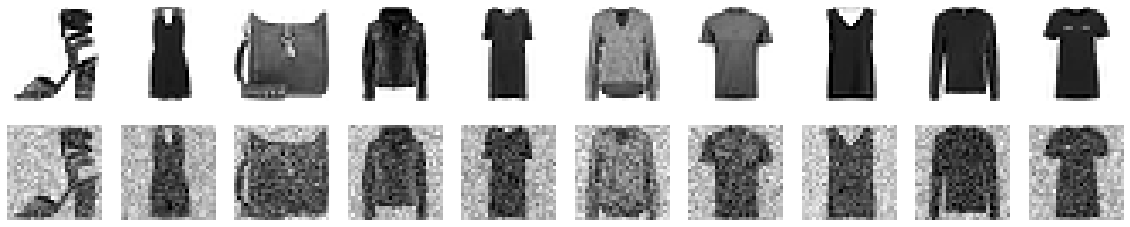

In [ ]:
def addGaussianNoise(tensor, mean, std):
  return tensor + torch.randn_like(tensor) * std + mean

images,_ = next(iter(iter_train))
noise_images = addGaussianNoise(images,0,0.15)

n_images = 10
fig = plt.figure(figsize=(n_images * 2, 4))
for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plt.imshow(images[image_index].squeeze(),
                   cmap="binary")
        plt.axis("off")
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plt.imshow(noise_images[image_index].squeeze(),
                   cmap="binary")
        plt.axis("off")

Ahora generemos una nueva red que en vez de eliminar un ruido producido por dropout, elimine un ruido gaussiano producido por la función `addGaussianNoise()`. Para hacerlo tenga en cuenta los siguientes detalles:


1.   El paquete nn.Module nos permite crear tanto capas como modelos completos personalizados. Utilice alguna de estas opciones para implementar este modelo.
2.   Tenga en cuenta que el ruido gaussiano solo debe agregarse a la imagen si el modelo está siendo entrenado. El atributo `training` de cualquier bloque que herede de nn.Module funciona como bandera que se pone en `True` si el modelo está entrenando y en `False` si ya está entrenada y se la usa para generar predicciones. El método `train()` pone esta bandera en `True` y el método `eval()` la pone en `False`



In [ ]:
## ingrese su código aquí


## Ejercicio 6: Entrenar el modelo con ruido gaussiano

Entrene el modelo creado en el ejercicio anterior

In [ ]:
#ingrese su código aquí

In [ ]:
#@title Grafique Predicciones de Validación
# Codigo adicional para generar imágenes.
import numpy as np


def plot_reconstructions(model, images=iter_valid, n_images=10):
    input = addGaussianNoise(images,0,0.15)
    model.eval()
    reconstructions = np.clip(input[:n_images].squeeze().detach(), 0, 1)
    reconstructions = model(reconstructions).squeeze().detach()
    fig = plt.figure(figsize=(n_images * 2, 4))
    for image_index in range(n_images):
        plt.subplot(3, n_images, 1 + image_index)
        plt.imshow(images[image_index].squeeze(),
                   cmap="binary")
        plt.axis("off")
        plt.subplot(3, n_images, 1 + n_images + image_index)
        plt.imshow(input[image_index].squeeze(),
                   cmap="binary")
        plt.axis("off")
        plt.subplot(3, n_images, 1 + 2 * n_images + image_index)
        plt.imshow(reconstructions[image_index], cmap="binary")
        plt.axis("off")

net.eval()
plot_reconstructions(netGaussian1, next(iter(iter_valid))[0])
plt.show()